# 2019-10-22_fundamentallearning_pytorchWordRNN_translation

### TODO
- follow this tutorial https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
- use reloading on training loop https://github.com/julvo/reloading

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
import os
import re
import random
import requests
import unicodedata
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import itertools
import pdb
from time import time
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

import pytorch_tutorial.word_utils as word_utils
from pytorch_tutorial.word_utils import (
    prepare_data, 
    pair2tensors, 
    sentence2tensor,
    timedelta_string,
    SOS_token, 
    EOS_token, 
    MAX_LENGTH, 
    
)




In [30]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device is : {DEVICE}")

device is : cuda


Get french english translations from https://www.manythings.org/anki/fra-eng.zip and put them in a folder `pytorch_tutorial/data/fra-eng/fra.txt`


## Load and process data

filter for short sentences that start with 'i am', 'he is' etc

In [31]:
fra_lang, eng_lang, sentence_pairs = prepare_data('fra', 'eng')

Loading data
example loaded pair  ['va !', 'go .']
total sentance pairs in data : 175623
filtering data
Filtered sentence pairs in data : 13019
fra : 4790
eng : 3083


In [32]:
sentence_pairs[0]

['j ai ans .', 'i m .']

## Model 

In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, inout_dim, hidden_dim=256):
        super(EncoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(inout_dim, hidden_dim)
        self.encoder = nn.GRU(hidden_dim, hidden_dim)
        
    def forward(self,x,hidden):
        embedding = self.embedding(x).view(1,1,-1)
        output, hidden = self.encoder(embedding,hidden)
        return output,hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_dim, device=DEVICE)
    
class DecoderRNN(nn.Module):
    def __init__(self, inout_dim, hidden_dim=256):
        super(DecoderRNN,self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(inout_dim, hidden_dim)
        self.encoder = nn.GRU(hidden_dim, hidden_dim)
        self.hidden2out = nn.Linear(hidden_dim, inout_dim)
        self.softmax = nn.LogSoftmax(dim =1)
        
    def forward(self, x, hidden):
        embedding = self.embedding(x).view(1,1,-1)
        output, hidden = self.encoder(embedding, hidden)
        output = self.softmax(self.hidden2out(output[0]))
        
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_dim, device=DEVICE)
    
    
        

In [34]:
sentence_pairs[0]

['j ai ans .', 'i m .']

### Dummy pass into model

In [35]:
def random_infer(dset):
    dummy_pair = random.choice(dset)
    dummy_in = sentence2tensor(fra_lang, dummy_pair[0], DEVICE)
    dummy_out = sentence2tensor(eng_lang, dummy_pair[1], DEVICE)
    enc_h0 = enc.init_hidden()
    h = enc_h0

    for i in range(dummy_in.size(0)):
        _, h = enc(dummy_in[i],h)
    enc_h = h

    outs = []
    hidden = enc_h
    output = torch.tensor([[SOS_token]], device=DEVICE)
    for i in range(dummy_out.size(0)):
        output, h = dec(output,hidden)

        top_value, top_index = output.topk(1)  
        output = top_index.squeeze().detach()
        outs.append(output)


    [eng_lang.index2word[o.item()] for o in outs]
    print(f"x : {dummy_pair[0]}")
    print(f"y : {dummy_pair[1]}")
    print(f"ŷ : {' '.join([eng_lang.index2word[o.item()] for o in outs])}")



## training model

In [36]:
def eval_example(input_tensor, target_tensor, enc, dec, optimizer, criterion, teacher_forcing=0.5):
    encoder_hidden = enc.init_hidden()
    optimizer.zero_grad()
    loss = 0
    
    target_length = input_tensor.size(0)
    
    for ei in range(target_length):
        _, encoder_hidden = enc(input_tensor[ei], encoder_hidden)
        
    decoder_input = torch.tensor([[SOS_token]],device=DEVICE)
    decoder_hidden = encoder_hidden
    
    for di in range(target_tensor.size(0)):
        decoder_input, decoder_hidden = dec(decoder_input, decoder_hidden)
        # for nll output = [batchsize, number of classes (words)] and target = correct class
        loss += criterion(decoder_input,target_tensor[di])
        if random.random()<teacher_forcing:
            decoder_input = target_tensor[di] #teacher forcing
        else:
            topv, topi = decoder_input.topk(1)
            decoder_input = topi.squeeze().detach()
    return loss

def train_step(input_tensor, target_tensor, enc, dec, optimizer, criterion):
    loss = eval_example(input_tensor, target_tensor, enc, dec, optimizer, criterion, teacher_forcing=True)
    loss.backward()
    optimizer.step()
    return loss.item()/ target_tensor.size(0)

def test_evaluate(test_set):
    loss_total = 0
    for i, pair in enumerate(test_set):
        input_tensor = pair[0]
        target_tensor = pair[1]
        
        with torch.no_grad():
            loss = eval_example(input_tensor, target_tensor, enc, dec, optimizer, criterion)
            loss_total += loss.item()/ target_tensor.size(0)
    return loss_total

def train(training_set, test_set, epochs, print_every):
    set_size = len(training_set)
    start_time = datetime.now()
    train_losses = []
    eval_losses = []
    train_loss_total = 0
    for e in range(epochs):
        for i, pair in enumerate(training_set):
            n_example = ((e)*set_size + (i+1))
            input_tensor = pair[0]
            target_tensor = pair[1]
            loss = train_step(input_tensor, target_tensor, enc, dec, optimizer, criterion)
            train_loss_total += loss

            if n_example%print_every ==0:
                timestamp = f"trainging time : {timedelta_string(datetime.now() - start_time)}"
                example_count = f"examples {n_example:8}"
                eval_loss = test_evaluate(test_set)/len(test_set)
                train_loss_total = train_loss_total/print_every
                eval_losses.append((n_example,eval_loss))
                train_losses.append((n_example,train_loss_total))
                print (f'epoch {e:3} | {example_count} | ave loss:{train_loss_total:5.4f} | ave test loss:{eval_loss:5.4f} | {timestamp}')
                train_loss_total = 0
    return train_losses, eval_losses


    

In [37]:
print(f"total examples {len(sentence_pairs)}")
def train_test_split(total_examples, training_size = 1000,test_size = 100):
    total_idx = [ i for i in range(len(total_examples))]
    training_idx = [random.choice(total_idx) for _ in range(training_size)]
    remaining_idx = list(set(total_idx) - set(training_idx))
    test_idx = [random.choice(remaining_idx) for _ in range(test_size)]
    assert set(test_idx).intersection(training_idx) == set([])
    
    training_examples = [total_examples[i] for i in training_idx]
    test_examples = [total_examples[i] for i in test_idx]
    
    
    training_set = [ pair2tensors(fra_lang, eng_lang, e , DEVICE) for e in training_examples]
    test_set = [pair2tensors(fra_lang, eng_lang, e, DEVICE) for e in test_examples]
    return training_set, test_set, training_examples, test_examples

total examples 13019


No attention: results

    epoch   2 | examples    36000 | loss: 1.06 | test loss: 4.52 | trainging time : 0:00:09:44.56
    
With many of the random examples looking like:
    
    ['ils ne sont pas prepares a ca .', 'they re not prepared for this .']
    ['they', 're', 'not', 'they', 're', 'not', 'they', 're']

## Attention models

In [38]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_dim, output_dim, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_dim, self.hidden_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.attn = nn.Linear(self.hidden_dim*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_dim * 2 , self.hidden_dim)
        self.gru = nn.GRU(self.hidden_dim, self.hidden_dim)
        self.out = nn.Linear(self.hidden_dim, self.output_dim)
        self.softmax = nn.Softmax(dim=1)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.ReLU()
        
    def forward(self, x, hidden, encoder_outputs):
        embedded = self.dropout(self.embedding(x).view(1, 1, -1)) # (1, 1, h_dim)
        
        # (1,2 * h_dim) -> (1, max_l)
        attn_weights = self.attn(torch.cat((hidden[0], embedded[0]), 1))
        attn_weights = self.softmax(attn_weights) 
        
        # (1,1,max_l) , (1,max_l,h_dim) - > (1, 1, h_dim)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        
        output = torch.cat((embedded[0], attn_applied[0]), 1) # (1,1, 2 * h_dim)
        output = self.relu(self.attn_combine(output).unsqueeze(0)) # (1,1, h_dim)
        
        output, hidden = self.gru(output, hidden)
        output = self.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights
        
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_dim, device=DEVICE)
    
    


In [39]:
def attn_test_evaluate(test_set):
    loss_total = 0
    for i, pair in enumerate(test_set):
        input_tensor = pair[0]
        target_tensor = pair[1]
        
        with torch.no_grad():
            loss = attn_eval_example(input_tensor, target_tensor, attn_enc, attn_dec, attn_optimizer, criterion)
            loss_total += loss.item()/ target_tensor.size(0)
    return loss_total
    
def attn_eval_example(input_tensor, target_tensor, attn_enc, attn_dec, attn_optimizer, criterion, teacher_forcing=0.5):
    encoder_hidden = attn_enc.init_hidden()
    attn_optimizer.zero_grad()
    loss = 0
    
    input_length = input_tensor.size(0)
    encoder_outputs = torch.zeros(MAX_LENGTH, attn_enc.hidden_dim, device=DEVICE)
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = attn_enc(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0,0]
        
    dec_input = torch.tensor([[SOS_token]],device=DEVICE)
    dec_hidden = encoder_hidden
    
    
    
    for di in range(target_tensor.size(0)):
        dec_input, dec_hidden, dec_attention = attn_dec(dec_input, dec_hidden, encoder_outputs)
        # for nll output = [batchsize, number of classes (words)] and target = correct class
        loss += criterion(dec_input,target_tensor[di])
        
        if random.random()<teacher_forcing:
            dec_input = target_tensor[di] #teacher forcing
        else:
            topv, topi = dec_input.topk(1)
            dec_input = topi.squeeze().detach()
            if dec_input.item() == EOS_token:
                break
    return loss

def attn_train_step(input_tensor, target_tensor, attn_enc, attn_dec, attn_optimizer, criterion):
    loss = attn_eval_example(input_tensor, target_tensor, attn_enc, attn_dec, attn_optimizer, criterion, teacher_forcing=True)
    loss.backward()
    attn_optimizer.step()
    return loss.item()/ target_tensor.size(0)



def attn_train(training_set, test_set, epochs, print_every):
    set_size = len(training_set)
    start_time = datetime.now()
    
    train_losses = []
    eval_losses = []
    train_loss_total = 0
    for e in range(epochs):
        for i, pair in enumerate(training_set):
            n_example = ((e)*set_size + (i+1))
            input_tensor = pair[0]
            target_tensor = pair[1]
            
            loss = attn_train_step(input_tensor, target_tensor, attn_enc, attn_dec, attn_optimizer, criterion)
            train_loss_total += loss

            if n_example%print_every ==0:
                timestamp = f"trainging time : {timedelta_string(datetime.now() - start_time)}"
                example_count = f"examples {n_example:8}"
                eval_loss = attn_test_evaluate(test_set)/len(test_set)
                train_loss_total = train_loss_total/print_every
                eval_losses.append((n_example,eval_loss))
                train_losses.append((n_example,train_loss_total))
                print (f'epoch {e:3} | {example_count} | ave loss:{train_loss_total:5.4f} | ave test loss:{eval_loss:5.4f} | {timestamp}')
                train_loss_total = 0
    return train_losses, eval_losses

    
    

In [40]:
def attn_random_infer(dset):
    dummy_pair = random.choice(dset)
    dummy_in = sentence2tensor(fra_lang, dummy_pair[0], DEVICE)
    dummy_out = sentence2tensor(eng_lang, dummy_pair[1], DEVICE)
    enc_h0 = attn_enc.init_hidden()
    h = enc_h0
    
    enc_outputs = torch.zeros(MAX_LENGTH, attn_enc.hidden_dim, device=DEVICE)
    for i in range(dummy_in.size(0)):
        o, h = attn_enc(dummy_in[i], h)
        enc_outputs[i] = o[0,0]
    enc_h = h

    outs = []
    hidden = enc_h
    output = torch.tensor([[SOS_token]], device=DEVICE)
    for i in range(dummy_out.size(0)*2):
        output, hidden, attention_weights = attn_dec(output, hidden, enc_outputs)

        top_value, top_index = output.topk(1)  
        output = top_index.squeeze().detach()
        outs.append(output)
        if output.item()==EOS_token:
            break

    print(f"x : {dummy_pair[0]}")
    print(f"y : {dummy_pair[1]}")
    print(f"ŷ : {' '.join([eng_lang.index2word[o.item()] for o in outs])}")

## Training comparison

In [41]:
training_set, test_set, training_examples, test_examples = train_test_split(sentence_pairs, 13000, 1000)

### normal rnn

In [42]:
enc = EncoderRNN(fra_lang.n_words, hidden_dim=256).to(DEVICE)
dec = DecoderRNN(eng_lang.n_words, hidden_dim=256).to(DEVICE)
criterion = nn.NLLLoss()
optimizer = optim.SGD(itertools.chain(enc.parameters(),dec.parameters()),lr=0.01)

In [43]:
random_infer(training_examples)

x : il est helvete .
y : he s swiss .
ŷ : jam slightly astonished safe grandfather


In [44]:
train_losses, test_losses = train(training_set, test_set, 6, 1000)

epoch   0 | examples     1000 | ave loss:3.4854 | ave test loss:3.9783 | trainging time : 0:00:00:14.93
epoch   0 | examples     2000 | ave loss:2.8252 | ave test loss:3.5748 | trainging time : 0:00:00:34.92
epoch   0 | examples     3000 | ave loss:2.5349 | ave test loss:3.3445 | trainging time : 0:00:00:54.92
epoch   0 | examples     4000 | ave loss:2.4164 | ave test loss:3.3134 | trainging time : 0:00:01:14.77
epoch   0 | examples     5000 | ave loss:2.2880 | ave test loss:3.1823 | trainging time : 0:00:01:34.61
epoch   0 | examples     6000 | ave loss:2.1707 | ave test loss:3.1291 | trainging time : 0:00:01:54.64
epoch   0 | examples     7000 | ave loss:2.0792 | ave test loss:2.9241 | trainging time : 0:00:02:14.50
epoch   0 | examples     8000 | ave loss:2.0175 | ave test loss:3.0497 | trainging time : 0:00:02:34.62
epoch   0 | examples     9000 | ave loss:1.9903 | ave test loss:2.9174 | trainging time : 0:00:02:54.61
epoch   0 | examples    10000 | ave loss:1.9002 | ave test loss:

In [45]:
for i in range(1):
    print(f"= {i} =")
    random_infer(training_examples)

= 0 =
x : je n en suis simplement pas sur .
y : i m just not sure .
ŷ : i m just m just m just


In [46]:
for i in range(1):
    print(f"= {i} =")
    random_infer(test_examples)

= 0 =
x : je manque de pratique .
y : i m out of practice .
ŷ : i m i m i m i


### rnn with attention

In [50]:
attn_dec = AttnDecoderRNN(hidden_dim=256, output_dim=eng_lang.n_words).to(DEVICE)
attn_enc = EncoderRNN(fra_lang.n_words, hidden_dim=256).to(DEVICE)
attn_optimizer = optim.SGD(itertools.chain(attn_enc.parameters(),attn_dec.parameters()),lr=0.01)

In [51]:
attn_random_infer(training_examples)

x : il est incroyablement talentueux .
y : he s incredibly talented .
ŷ : windows windows totally silly finicky finicky finicky finicky finicky finicky finicky finicky


In [ ]:
attn_train_losses, attn_eval_losses = attn_train(training_set, test_set, 6, 1000)

epoch   0 | examples     1000 | ave loss:3.5015 | ave test loss:3.8358 | trainging time : 0:00:00:23.47
epoch   0 | examples     2000 | ave loss:2.8272 | ave test loss:3.2552 | trainging time : 0:00:00:54.97
epoch   0 | examples     3000 | ave loss:2.4987 | ave test loss:3.0895 | trainging time : 0:00:01:26.41
epoch   0 | examples     4000 | ave loss:2.3753 | ave test loss:3.0886 | trainging time : 0:00:01:57.65
epoch   0 | examples     5000 | ave loss:2.2608 | ave test loss:2.9798 | trainging time : 0:00:02:29.20
epoch   0 | examples     6000 | ave loss:2.1261 | ave test loss:2.7933 | trainging time : 0:00:03:00.51
epoch   0 | examples     7000 | ave loss:2.0470 | ave test loss:2.7056 | trainging time : 0:00:03:31.80
epoch   0 | examples     8000 | ave loss:2.0054 | ave test loss:2.7492 | trainging time : 0:00:04:03.29
epoch   0 | examples     9000 | ave loss:1.9525 | ave test loss:2.6186 | trainging time : 0:00:04:35.03
epoch   0 | examples    10000 | ave loss:1.8671 | ave test loss:

In [59]:
for i in range(1):
    print(f"= {i} =")
    attn_random_infer(training_examples)
    

= 0 =
x : je suis un bon enseignant .
y : i m a good teacher .
ŷ : i m a good teacher . EOS


In [70]:
for i in range(1):
    print(f"= {i} =")
    attn_random_infer(test_examples)
    

= 0 =
x : je suis heureux avec ce que j ai .
y : i m happy with what i ve got .
ŷ : i m happy with your father . EOS


### Training graphs

In [67]:
def plot_training(train_losses, test_losses, ax, model):
    tdf = pd.DataFrame(train_losses,columns=['epoch', 'loss'])
    edf = pd.DataFrame(test_losses,columns=['epoch', 'loss'])
    ax.plot(tdf.epoch,tdf.loss,  label=f'{model} training loss', alpha=0.8)
    ax.plot(edf.epoch,edf.loss,  label=f'{model} test loss', alpha=0.8, linewidth=2)
    ax.legend()
    
    

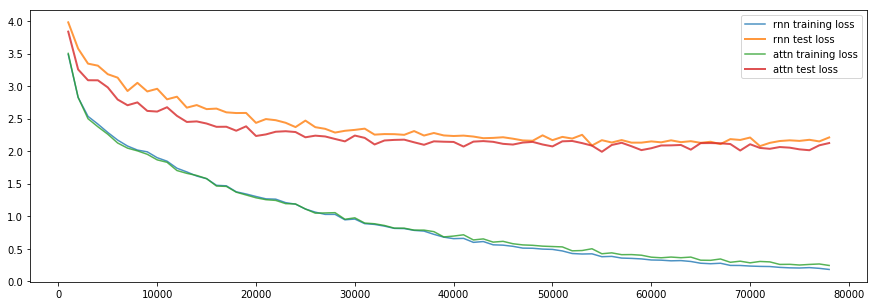

In [68]:
fig, ax = plt.subplots(figsize=(15,5), facecolor='white')
plot_training(train_losses, test_losses, ax, "rnn")
plot_training(attn_train_losses, attn_eval_losses, ax, "attn")